In [1]:
import numpy as np

# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio

import sys
sys.path.append('../../tools/')
import fitting_functions

import matplotlib.colors
import matplotlib.ticker as ticker

import scipy.optimize

In [ ]:
# Load R interface to do statistics
import rpy2.rinterface
%load_ext rpy2.ipython

In [2]:
matplotlib.rcParams.update({'font.size': 8, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

In [3]:
def prepareStepResponse(filename, full=True, num_components_extrap = 2, num_components_sr = 3, 
                        conservative=False, use_summary=False, trace_ind = 0):
    trange, eye_pos, pe_start_index, displacement_index, release_index, step_pos = fitting_functions.importActiveData('../../data/active/fixed/'+filename+'.mat')

    fish_name = filename[:-5]
    trange_mid = 72*2e-4*(np.arange(1, 16))
    trange_full = np.concatenate((trange[:release_index+1], trange_mid+trange[release_index], trange[release_index+1:]))

    if conservative:
        conservative_file = sio.loadmat('extrap/results/'+filename+'_conservative.mat')
        conservative_fit = conservative_file['fit'][0]
        if full:
            extrap = fitting_functions.exponentialModel(trange_full, conservative_fit)*eye_pos[0]
            fit_file = sio.loadmat('fit/results/conservative/'+fish_name+'_conservative.mat')
            lls_fit = fit_file['lls']
            fits = fit_file['fits']
            best_trace_ind = np.argmax(lls_fit[num_components_sr-1, :])
            sr_data_mid = fitting_functions.exponentialModel(trange_mid, fits[num_components_sr-1,0][best_trace_ind,:])*step_pos
        else:
            extrap = fitting_functions.exponentialModel(trange, conservative_fit)*eye_pos[0]

    else:
        extrap_file = sio.loadmat('extrap/results/'+filename +'.mat')
        lls = extrap_file['lls']
        fits_extrap = extrap_file['fits']
        best_fit_ind = np.argmax(lls[num_components_extrap-1,:])
        if full:
            extrap = fitting_functions.exponentialModel(trange_full, fits_extrap[num_components_extrap-1,0][best_fit_ind,:])*eye_pos[0]
            if use_summary:
                fit_file = sio.loadmat('plants/summary-plant/sr_fits.mat')
                lls_fit = fit_file['lls']
                fits = fit_file['fits']
                best_trace_ind = np.argmax(lls_fit[2, :])
                sr_data_mid = fitting_functions.exponentialModel(trange_mid, fits[2,trace_ind][best_trace_ind,:])*step_pos
            else:
                fit_file = sio.loadmat('fit/results/best/'+fish_name+'.mat')
                lls_fit = fit_file['lls']
                fits = fit_file['fits']
                best_trace_ind = np.argmax(lls_fit[num_components_sr-1, :])
                sr_data_mid = fitting_functions.exponentialModel(trange_mid, fits[num_components_sr-1,0][best_trace_ind,:])*step_pos
        else:
            extrap = fitting_functions.exponentialModel(trange, fits_extrap[num_components_extrap-1,0][best_fit_ind,:])*eye_pos[0]


    if full:
        eye_data =  eye_pos[displacement_index:]
        sr_data = extrap[displacement_index:] - np.insert(eye_data, release_index-displacement_index+1, sr_data_mid)
        sr_trange = trange_full[displacement_index:] - trange_full[displacement_index]
    else:
        sr_data = extrap[displacement_index:] - eye_pos[displacement_index:]
        sr_trange = trange[displacement_index:] - trange[displacement_index]

    return sr_trange, sr_data, release_index-displacement_index+1

In [4]:
def deconvolveEyePos(trange, eye_pos, plant, ind=-1):
    plant_model = fitting_functions.exponentialModel(trange, plant)
    dt = trange[2]-trange[1]
    
    def convMat(signal, m):
        mat = np.zeros((len(signal), m))
        mat[:,0] = signal
        for i in range(1, m):
            mat[i:,i] = signal[:len(signal)-i]
        return mat
    
    if ind == -1:
        ind = len(trange)
    mat = dt*convMat(plant_model, ind)
    optresult = scipy.optimize.lsq_linear(mat, eye_pos, bounds=(0, np.inf))
    f_ = np.zeros(len(trange))
    f_[:len(optresult.x)] = optresult.x
    return f_

In [5]:
file_names = [('090711e_0006',), ('090811c_0002',), ('090811d_0002','090811d_0004',),
   ('091111a_0001', '091111a_0003'), ('091111c_0003',), ('091211a_0002', '091211a_0005')]

In [6]:
best_num_components_sr_best = {'090711e':3, '090811c':3, '090811d':3, '091111a':4, '091111c':3, '091211a':3}
best_num_components_sr_conservative = {'090711e':3, '090811c':3, '090811d':4, '091111a':4, '091111c':3, '091211a':3}

best_num_components_extrap = {'090711e_0006':2, '090811c_0002':2, '090811d_0002':2, '090811d_0004':2,'091111a_0001':2,
                    '091111a_0003':3,'091111c_0003':2,'091211a_0002':2,'091211a_0005':2}


In [7]:
def calculateAUC(plant_params, T = 20, total=False, normalized=True):
    n = len(plant_params)//2
    sort_order = np.flip(np.argsort(plant_params[n:]))
    timeconstants = plant_params[n+sort_order]
    c = plant_params[sort_order]
    
    
    aucs = np.zeros(n)
    for k in range(n):
        if timeconstants[k] > 0:
            aucs[k] = 1./timeconstants[k]*c[k]*(1-np.exp(-T*timeconstants[k]))
        else:
            aucs[k] = c[k]*T
    if total:
        return np.sum(aucs)
    else:
        if normalized:
            return aucs/np.sum(aucs)
        else:
            return aucs

# Parameter summary

In [9]:
plants_best = {}
plants_conservative = {}

for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    n = best_num_components_sr_best[fish_name]
    n_conservative = best_num_components_sr_conservative[fish_name]

    ### Load results for best extrapolation
    deconv_file = sio.loadmat('deconv/results/best/distributed/'+fish_name+'.mat')

    fit_file = sio.loadmat('fit/results/best/'+fish_name+'.mat')
    lls_fit = fit_file['lls']
    fits = fit_file['fits']
    best_trace_ind = np.argmax(lls_fit[n-1, :])
    timeconstants = fits[n-1,0][best_trace_ind,n:]
    
    plants_best[fish_name] = np.concatenate((deconv_file['c'][0], timeconstants))
    
    ### Load results for conservative extrapolation
    deconv_file = sio.loadmat('deconv/results/conservative/distributed/'+fish_name+'.mat')

    fit_file = sio.loadmat('fit/results/conservative/'+fish_name+'_conservative.mat')
    lls_fit = fit_file['lls']
    fits = fit_file['fits']
    best_trace_ind = np.argmax(lls_fit[n_conservative-1, :])
    timeconstants = fits[n_conservative-1,0][best_trace_ind,n_conservative:]
    
    plants_conservative[fish_name] = np.concatenate((deconv_file['c'][0], timeconstants))

In [41]:
## Save plants to file
for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    
    sio.savemat('plants/best/distributed/'+fish_name+'.mat', {'plant':plants_best[fish_name]})
    sio.savemat('plants/conservative/distributed/'+fish_name+'.mat', {'plant':plants_conservative[fish_name]})

In [8]:
# Load plants from file
plants_best = {}
plants_conservative = {}

for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    plants_best[fish_name] = sio.loadmat('plants/best/distributed/'+fish_name+'.mat')['plant'][0]
    plants_conservative[fish_name] = sio.loadmat('plants/conservative/distributed/'+fish_name+'.mat')['plant'][0]

## Figure 5E: parameter summary for plants w/ best extrapolation

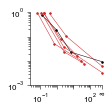

In [15]:
plt.figure(figsize=(1.3, 1.3))
plt.xscale('log')
plt.yscale('log')
for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    n = best_num_components_sr_best[fish_name]

    if n == 3:
        plt.plot(1/np.maximum(plants_best[fish_name][n:], 1/5e2), plants_best[fish_name][:n],'.-', ms=3, c='C3', lw=0.5, clip_on=False)
    else:
        plt.plot(1/np.maximum(plants_best[fish_name][n:], 1/5e2), plants_best[fish_name][:n], '.-', ms=3, c='k', lw=0.5, clip_on=False)
    
ax = plt.gca()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylim([1e-3, 1])
plt.xlim([0.25e-1, 3e2])
ax.xaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs='auto'))
ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax.set_xticks([1e-1, 1e0, 1e1, 1e2, 5e2])
ax.set_xticklabels([r'$10^{-1}$',  '', '', r'$10^{2}$', r'$\infty$']);

ax.yaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs='auto'))
ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0])
ax.set_yticklabels([r'$10^{-3}$', '', '', r'$10^{0}$']);

# to display axes fully in frame
plt.subplots_adjust(left = 0.21, top = 0.96, bottom=0.18, right=0.98)

## Figure 5F: area under the curve for plant components (best extrapolation)

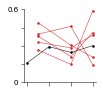

In [18]:
fig = plt.figure(figsize=(1.3,1.3))
ax = plt.gca()
for j in range(len(file_names)):
    fish = file_names[j][0][:-5]
    n = best_num_components_sr_best[fish]
    if n == 3:
        plt.plot([1.5, 3, 4], calculateAUC(plants_best[fish]),'.-', lw=0.5, ms=3, c='C3')
    else:
        plt.plot([1, 2, 3, 4], calculateAUC(plants_best[fish]),'.-', lw=0.5, ms=3, c='k')


plt.ylim([0, 0.6])
plt.yticks(np.linspace(0, 0.6, 5))
ax.set_yticklabels([0, '', '', '', 0.6 ])

ax.set_xticks([1,2,3,4])
ax.set_xticklabels([])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplots_adjust(left = 0.21, top = 0.96, bottom=0.18, right=0.98)

## Parameter summary for plants w/ conservative extrapolation

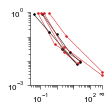

In [16]:
plt.figure(figsize=(1.3, 1.3))
plt.xscale('log')
plt.yscale('log')
for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    n = best_num_components_sr_conservative[fish_name]

    if n == 3:
        plt.plot(1/np.maximum(plants_conservative[fish_name][n:], 1/5e2), plants_conservative[fish_name][:n],'.-', ms=3, c='C3', lw=0.5, clip_on=False)
    else:
        plt.plot(1/np.maximum(plants_conservative[fish_name][n:], 1/5e2), plants_conservative[fish_name][:n], '.-', ms=3, c='k', lw=0.5, clip_on=False)
    
ax = plt.gca()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylim([1e-3, 1])
plt.xlim([0.25e-1, 3e2])
ax.xaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs='auto'))
ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax.set_xticks([1e-1, 1e0, 1e1, 1e2, 5e2])
ax.set_xticklabels([r'$10^{-1}$',  '', '', r'$10^{2}$', r'$\infty$']);

ax.yaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs='auto'))
ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0])
ax.set_yticklabels([r'$10^{-3}$', '', '', r'$10^{0}$']);

# to display axes fully in frame
plt.subplots_adjust(left = 0.21, top = 0.96, bottom=0.18, right=0.98)

## Area under curve for plant components (conservative extrapolation)

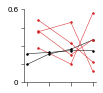

In [19]:
fig = plt.figure(figsize=(1.3,1.3))
ax = plt.gca()
for j in range(len(file_names)):
    fish = file_names[j][0][:-5]
    n = best_num_components_sr_conservative[fish]
    if n == 3:
        plt.plot([1.5, 3, 4], calculateAUC(plants_conservative[fish]),'.-', lw=0.5, ms=3, c='C3')
    else:
        plt.plot([1, 2, 3, 4], calculateAUC(plants_conservative[fish]),'.-', lw=0.5, ms=3, c='k')


plt.ylim([0, 0.6])
plt.yticks(np.linspace(0, 0.6, 5))
ax.set_yticklabels([0, '', '', '', 0.6 ])

ax.set_xticks([1,2,3,4])
ax.set_xticklabels([])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplots_adjust(left = 0.21, top = 0.96, bottom=0.18, right=0.98)

# Fit quality evaluation

In [47]:
def R2(data,fit):
    try:
        x = data.shape[0]
        sstot = np.sum((fit - np.mean(data))**2)
        sse = np.sum((fit - data)**2)
    except:
        sstot = np.sum([np.sum((fit[i] - np.mean(data[i]))**2) for i in range(len(data))])
        sse = np.sum([np.sum((fit[i] - data[i])**2) for i in range(len(data))])
    return 1-sse/sstot

In [76]:
r2s_reconstr = np.zeros((2, 6))
i = 0
for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    
    n = best_num_components_sr_best[fish_name]
    n_conservative = best_num_components_sr_conservative[fish_name]
    
    sr_data_all = [[] for i in range(len(file_names[fish_num]))]
    reconstr_all_best = [[] for i in range(len(file_names[fish_num]))]
    
    sr_data_all_conservative = [[] for i in range(len(file_names[fish_num]))]
    reconstr_all_conservative = [[] for i in range(len(file_names[fish_num]))]
    
    for trace_num in range(len(file_names[fish_num])):
        sr_trange_full, sr_data_full, ind_full = prepareStepResponse(file_names[fish_num][trace_num], num_components_sr=n, num_components_extrap=n_extrap)
        f = deconvolveEyePos(sr_trange_full, sr_data_full/sr_data_full[ind_full-1], plants_best[fish_name], ind_full)
        f = np.copy(f)
        f[ind_full-1] = f[ind_full-2]
        
        plant_model = fitting_functions.exponentialModel(sr_trange_full, plants_best[fish_name])
        reconstr = 72*2e-4*np.convolve(plant_model, f)[:len(f)]
        
        sr_trange_plot, sr_data_plot, ind_plot = prepareStepResponse(file_names[fish_num][trace_num], num_components_sr=n, num_components_extrap=n_extrap, full=False)
        sr_data_all[trace_num] = sr_data_plot[ind_plot:]/sr_data_plot[ind_plot-1]
        reconstr_all_best[trace_num] = reconstr[ind_full+15:]
        
        # Conservative
        sr_trange_full, sr_data_full, ind_full = prepareStepResponse(file_names[fish_num][trace_num],num_components_sr=n_conservative, num_components_extrap=n_extrap, conservative=True)
        f = deconvolveEyePos(sr_trange_full, sr_data_full/sr_data_full[ind_full-1], plants_conservative[fish_name], ind_full)
        f = np.copy(f)
        f[ind_full-1] = f[ind_full-2]
        
        plant_model = fitting_functions.exponentialModel(sr_trange_full, plants_conservative[fish_name])
        reconstr = 72*2e-4*np.convolve(plant_model, f)[:len(f)]
        
        sr_trange_plot, sr_data_plot, ind_plot = prepareStepResponse(file_names[fish_num][trace_num],num_components_sr=n_conservative, num_components_extrap=n_extrap, full=False, conservative=True)
        sr_data_all_conservative[trace_num] = sr_data_plot[ind_plot:]/sr_data_plot[ind_plot-1]
        reconstr_all_conservative[trace_num] = reconstr[ind_full+15:]
    
    r2s_reconstr[0,i] = R2(sr_data_all, reconstr_all_best)
    r2s_reconstr[1,i] = R2(sr_data_all_conservative, reconstr_all_conservative)
    i += 1

In [77]:
np.mean(r2s_reconstr, axis=1)

array([0.93608061, 0.96026434])

In [78]:
np.std(r2s_reconstr, axis=1)

array([0.07283094, 0.04927981])

# Example traces

In [10]:
example_fish = 4
example_trace_num = 0
example_trace = file_names[example_fish][example_trace_num]
fish_name = example_trace[:-5]
n = best_num_components_sr_best[fish_name]
n_extrap = best_num_components_extrap[example_trace]

# Import data
sr_trange_full, sr_data_full, ind_full = prepareStepResponse(example_trace, num_components_sr = n, num_components_extrap=n_extrap, full=True)
f_original = deconvolveEyePos(sr_trange_full, sr_data_full/sr_data_full[ind_full-1], plants_best[fish_name], ind_full)

# remove "blip" at release time
f_original[ind_full-1] = f_original[ind_full-2]

plant_model = fitting_functions.exponentialModel(sr_trange_full, plants_best[fish_name])
reconstr = 72*2e-4*np.convolve(plant_model, f_original)[:len(f_original)]

In [11]:
sr_trange_plot, sr_data_plot, ind_plot = prepareStepResponse(example_trace,  num_components_sr = n, num_components_extrap=n_extrap, full=False)

## Figure 5B: reconstructed eye position from blind deconvolution (best extrapolation)

In [17]:
dt = 72*2e-4
t_final_example = int(2/dt) + ind_plot
t_final_example_full = int(2/dt) + ind_full

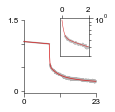

In [32]:
plt.figure(figsize=(1.3, 1.3))
plt.plot(sr_trange_plot[:ind_plot], sr_data_plot[:ind_plot]/sr_data_plot[ind_plot-1], c=(0.7, 0.7, 0.7, 1), clip_on=False)
plt.plot(sr_trange_plot[ind_plot:], sr_data_plot[ind_plot:]/sr_data_plot[ind_plot-1], c=(0.7, 0.7, 0.7, 1), clip_on=False)
plt.plot(sr_trange_full, reconstr, lw=0.75, c='C3', clip_on=False, zorder=10)

plt.ylim([-0.05, 1.5])

ax = plt.gca()
ax.set_yticks(np.linspace(0,1.5,4))
ax.set_yticklabels([0,'','',1.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim([0, int(np.ceil(sr_trange_full[-1]))])

ax.set_xticks(np.linspace(0, int(np.ceil(sr_trange_full[-1])), 3))
ax.set_xticklabels([0, '', int(np.ceil(sr_trange_full[-1]))])

ax1 = plt.axes([.6, .58, 0.3, .4])
plt.yscale('log')
plt.plot(sr_trange_plot[ind_plot:t_final_example]-sr_trange_plot[ind_plot-1], sr_data_plot[ind_plot:t_final_example]/sr_data_plot[ind_plot-1], color=(0.75,)*3)
plt.plot(sr_trange_full[ind_full:t_final_example_full]-sr_trange_full[ind_full-1], reconstr[ind_full:t_final_example_full],c='C3', linewidth=0.5)

ax1.set_ylim([3e-1, 1])
ax1.set_xlim([-0.1, 2])
ax1.set_yticklabels([],minor=True)
ax1.yaxis.tick_right()
ax1.xaxis.tick_top()

plt.subplots_adjust(left=0.21, right=0.98, bottom=0.18, top=0.96)

## Figure 5C: applied force profile

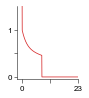

In [36]:
plt.figure(figsize=(1.1, 1.3))

plt.plot(sr_trange_full, f_original/f_original[1], lw=0.75, c='C3')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlim([-2, sr_trange_full[-1]])
plt.ylim([-0.05, 1.5])

ax.set_yticks(np.linspace(0, 1, 3))
ax.set_yticklabels([0, '', 1])

ax.set_xticks(np.linspace(0, int(np.ceil(sr_trange_full[-1])), 3))
ax.set_xticklabels([0, '', int(np.ceil(sr_trange_full[-1]))])

plt.subplots_adjust(left=0.21, right=0.98, bottom=0.18, top=0.96)

## Figure 5D: plant time course

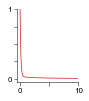

In [37]:
plt.figure(figsize=(1.1, 1.3))
plt.plot(sr_trange_full, plant_model, c='C3', lw=0.75)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(np.linspace(0,1,5))
ax.set_yticklabels([0,'','','', 1])
ax.set_xticks([0, 5, 10]),
ax.set_xticklabels([0,'', 10])
plt.ylim([-0.05, 1])
plt.xlim([-0.5, 10])


plt.subplots_adjust(left=0.21, right=0.98, bottom=0.18, top=0.96)

# Calculate neural drive

## Deconvolve saccades

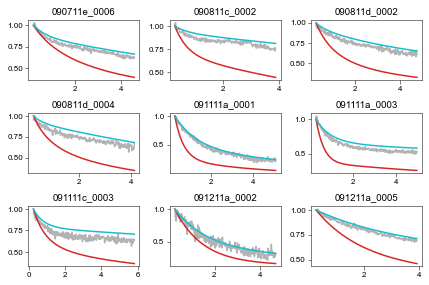

In [10]:
drive_persistence = np.zeros(9)
eye_persistence_raw = np.zeros(9)
drive_persistence_fast = np.zeros(9)
T_start = 17 # = 245 ms, offset from saccade end

fast_plant = np.array([0.4, 0.6, 1/0.02, 1/0.2]) # From Robinson et al. 1990

j = 0
for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    
    n = best_num_components_sr_best[fish_name]
    timeconstants = plants_best[fish_name][n:]

    for trace_num in range(len(file_names[fish_num])):
        saccade_data_file = sio.loadmat('saccades/fit/'+file_names[fish_num][trace_num]+'.mat')
        trange_sacc = saccade_data_file['trange'][0]
        eye_pos_sacc = saccade_data_file['model'][0]
        eye_pos_sacc_raw = saccade_data_file['data'][0]
        
        n_sacc = len(saccade_data_file['fit'][0])
        
        # calculate eye persistence
        eye_persistence_raw[j] = np.sum(eye_pos_sacc_raw[T_start:]/eye_pos_sacc_raw[T_start])/len(eye_pos_sacc_raw[T_start:])
        
        # now, deconvolve with plant and calculate persistence
        drive = deconvolveEyePos(trange_sacc, eye_pos_sacc, plants_best[fish_name])
        drive_persistence[j] = np.sum(drive[T_start:]/drive[T_start])/len(drive[T_start:])
        
        # Repeat for fast plant
        
        drive_fast = deconvolveEyePos(trange_sacc, eye_pos_sacc, fast_plant)
        drive_persistence_fast[j] = np.sum(drive_fast[T_start:]/drive_fast[T_start])/len(drive_fast[T_start:])
        
        plant_fast = fitting_functions.exponentialModel(trange_sacc,fast_plant)
        reconstr_fast = 72*2e-4*np.convolve(plant_fast, drive_fast)[:len(trange_sacc)]
        j += 1
        
        plt.subplot(3,3,j)
        plt.plot(trange_sacc[T_start:], eye_pos_sacc_raw[T_start:]/eye_pos_sacc[T_start], c=(0.7,)*3)
        plt.plot(trange_sacc[T_start:],drive[T_start:]/drive[T_start], c='C3')
        plt.plot(trange_sacc[T_start:],drive_fast[T_start:]/drive_fast[T_start], c='C9')
        plt.title(file_names[fish_num][trace_num])
plt.tight_layout()

### Summary statistics

#### Distributed:

In [266]:
np.median(drive_persistence/eye_persistence_raw)

0.7138715126009416

In [267]:
np.percentile(drive_persistence/eye_persistence_raw,25),np.percentile(drive_persistence/eye_persistence_raw,75)

(0.6724052583840436, 0.7558638003744299)

In [11]:
%%R -i drive_persistence -i eye_persistence_raw
wilcox.test(eye_persistence_raw, drive_persistence, alternative="greater", paired=TRUE, exact=TRUE)

data:  eye_persistence_raw and drive_persistence

V = 45, p-value = 0.001953

alternative hypothesis: true location shift is greater than 0

#### Fast:

In [268]:
np.median(drive_persistence_fast/eye_persistence_raw)

1.055422186114964

In [269]:
np.percentile(drive_persistence_fast/eye_persistence_raw,25),np.percentile(drive_persistence_fast/eye_persistence_raw,75)

(1.0416111089910989, 1.0660077134160435)

In [12]:
%%R -i drive_persistence_fast -i eye_persistence_raw
wilcox.test(eye_persistence_raw, drive_persistence_fast, alternative="two.sided", paired=TRUE, exact=TRUE)

#### One sided
data:  eye_persistence_raw and drive_persistence_fast
    
V = 0, p-value = 1

alternative hypothesis: true location shift is greater than 0

#### Two sided
data:  eye_persistence_raw and drive_persistence_fast

V = 0, p-value = 0.003906

alternative hypothesis: true location shift is not equal to 0

## Fig. 7E Plot drive vs eye persistences for distributed/fast plants:

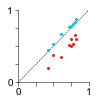

In [285]:
plt.figure(figsize=(1.3,1.3))

plt.plot([0, 1], [0,1], '--', c='k',lw=0.5, clip_on=False)

plt.plot(eye_persistence_raw, drive_persistence,  '.', ms=4, c='C3', clip_on=False)
plt.plot(eye_persistence_raw,drive_persistence_fast,  '.', ms=4, c='C9', clip_on=False)

plt.xlim([0,1])
plt.ylim([0,1])
ax = plt.gca()
ax.set_yticks(np.linspace(0, 1, 5))
ax.set_xticks(np.linspace(0, 1, 5))
ax.set_xticklabels([0,'', '', '',  1])
ax.set_yticklabels([0, '', '', '', 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.figtext(0.97, 0.225, 'Distributed', color='C3', horizontalalignment='right')
# plt.figtext(0.97, 0.325, 'Fast', color='C9', horizontalalignment='right')


plt.subplots_adjust(left=0.21, right=0.96, bottom=0.18, top=0.95)

## Figure 7B: Ideal drive for distributed/fast plants:

In [287]:
fish_num = 4
trace_num = 0


fish_name = file_names[fish_num][0][:-5]

saccade_data_file = sio.loadmat('saccades/fit/'+file_names[fish_num][trace_num]+'.mat')
trange_sacc = saccade_data_file['trange'][0]
eye_pos_sacc = saccade_data_file['model'][0]
eye_pos_sacc_raw = saccade_data_file['data'][0]

drive_stable = deconvolveEyePos(trange_sacc, np.ones(len(trange_sacc)), plants_best[fish_name])
drive_stable_fast = deconvolveEyePos(trange_sacc, np.ones(len(trange_sacc)), fast_plant)

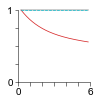

In [291]:
plt.figure(figsize=(1.3, 1.3))
plt.plot([trange_sacc[T_start], trange_sacc[-1]], [1, 1], c=(0.75, 0.75, 0.75, 1), clip_on=False)
plt.plot(trange_sacc[T_start:], drive_stable[T_start:]/drive_stable[T_start], c='C3', lw=0.75, clip_on=False)
plt.plot(trange_sacc[T_start:], drive_stable_fast[T_start:]/drive_stable_fast[T_start], c= 'C9', lw=0.75, ls='--', clip_on=False)

plt.ylim([0, 1])
plt.xlim([0, trange_sacc[-1]])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks(np.linspace(0,6,7))
ax.set_xticklabels([0, '', '', '', '','',6])

ax.set_yticks(np.linspace(0, 1, 5))
ax.set_yticklabels([0, '', '', '', 1])

plt.subplots_adjust(left=0.21, right=0.98, top=0.95, bottom=0.18)

## Figure 7C: Drive to produce measured fixation

In [288]:
drive = deconvolveEyePos(trange_sacc, eye_pos_sacc, plants_best[fish_name])
drive_fast = deconvolveEyePos(trange_sacc, eye_pos_sacc, fast_plant)

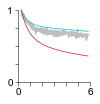

In [292]:
plt.figure(figsize=(1.3, 1.3))

plt.plot(trange_sacc[T_start:], eye_pos_sacc_raw[T_start:]/eye_pos_sacc_raw[T_start], clip_on=False, c=(0.75, 0.75, 0.75, 1))

plt.plot(trange_sacc[T_start:], drive[T_start:]/drive[T_start], c='C3', lw=0.75, clip_on=False)
plt.plot(trange_sacc[T_start:], drive_fast[T_start:]/drive_fast[T_start], c= 'C9', lw=0.75, clip_on=False)

plt.ylim([0, 1])
plt.xlim([0, trange_sacc[-1]])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([0, 1,2,3,4,5,6])

ax.set_xticklabels([0, '', '', '', '', '', 6])

ax.set_yticks(np.linspace(0, 1, 5))
ax.set_yticklabels([0, '', '', '', 1])


plt.subplots_adjust(left=0.21, right=0.98, top=0.95, bottom=0.18)

# Slide component time constants vs. plant time constants

In [154]:
slides_best = {}

for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    n = best_num_components_sr_best[fish_name]
    
    # Construct polynomial for numerator of transfer function
    all_best = np.zeros(n)
    for j in range(n):
        all_i = np.zeros(n)
        for i in range(n):
            if i == j:
                continue
            if np.sum(all_i) == 0:
                all_i[n-2:] = np.array([1, -plants_best[fish_name][n+i]])
            else:
                all_i = np.convolve(all_i, np.array([1, -plants_best[fish_name][n+i]]), mode='full')[1:]
        all_best += -plants_best[fish_name][j]*np.copy(all_i)
    # Calculate roots of polynomial
    slides_best[fish_name] = np.copy(np.roots(all_best))

## Figure 7D

In [277]:
n = best_num_components_sr_best[fish_name]
plant_taus = 1/np.maximum(1e-3, plants_best[fish_name][n:])
slide_taus = 1/slides_best[fish_name]

In [278]:
plant_taus

array([ 0.11932409,  2.76099088, 43.08101555])

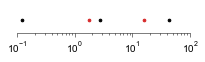

In [293]:
plt.figure(figsize=(2.5,0.5))
plt.xscale('log')
plt.scatter(plant_taus, np.ones(n), color='k', s=7);
plt.scatter(slide_taus, np.ones(n-1), color='C3',s=7, marker='o')

plt.ylim([0.7, 1.3])
plt.xlim([1e-1, 1e2])

ax = plt.gca()
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplots_adjust(bottom=0.25, top=1, left=0.02, right=0.98)

# Summary plant

In [8]:
fit_file_summary = sio.loadmat('plants/summary-plant/sr_fits.mat')
lls_summary = fit_file_summary['lls']
fits_summary = fit_file_summary['fits']
timeconstants = fits_summary[2,0][np.argmax(lls_summary[2,:]),3:]

deconv_file = sio.loadmat('plants/summary-plant/summary-plant-linear.mat')
plant_coeff = deconv_file['c'][0]

summary_plant = np.concatenate((plant_coeff, timeconstants))

In [9]:
summary_plant

array([0.94115949, 0.0502187 , 0.00862181, 5.4929605 , 0.38426069,
       0.03306899])

In [181]:
sio.savemat('plants/summary-plant.mat', {'plant':summary_plant})

## Figure 9A: time course of summary plant

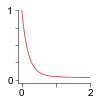

In [182]:
plant_trange = np.arange(0, 2, 72*2e-4)

distr_plant = fitting_functions.exponentialModel(plant_trange, summary_plant)

plt.figure(figsize=(1.3, 1.3))
plt.plot(plant_trange,  distr_plant, c='C3', lw=0.75)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim([-0.1, 2])
plt.ylim([-0.05, 1])

ax.set_yticks(np.linspace(0, 1, 5))
ax.set_yticklabels([0,'','','',1])

ax.set_xticks([0,1,2])
ax.set_xticklabels([0,'',2])

plt.subplots_adjust(left=0.21, bottom=0.18, right=0.98, top=0.96)

## Figure 9B: parameters of summary plant

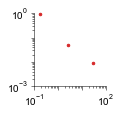

In [184]:
plt.figure(figsize=(1.3, 1.3))
plt.xscale('log')
plt.yscale('log')
plt.plot(1/summary_plant[3:], summary_plant[:3], '.', c='C3', ms=5, lw=0.75, clip_on=False)


ax = plt.gca()

ax.set_ylim([1e-3, 1])
ax.set_yticks([1e-3, 1e-2, 1e-1, 1])
ax.set_yticklabels([r'$10^{-3}$', '', '', r'$10^{0}$'])


ax.set_xticks([1e-1, 1e0, 1e1, 1e2])
ax.set_xticklabels([r'$10^{-1}$', '', '', r'$10^{2}$'])
ax.xaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs='auto'))
ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())

ax.yaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs='auto'))
ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplots_adjust(left=0.21, bottom=0.18, right=0.98, top=0.96)

## Compare fits with summary plant to individual fits

In [187]:
traces = [ '090711e_0006', '090811c_0002','090811d_0002','090811d_0004',
            '091111a_0001', '091111a_0003', '091111c_0003', '091211a_0002', '091211a_0005']

In [200]:
mses_summary = np.zeros(len(traces))
for i in range(len(traces)):
    # load fit
    sr_trange_full, sr_data_full, ind_full = prepareStepResponse(traces[i], 
                                                            num_components_extrap = best_num_components_extrap[file_names[fish_num][trace_num]], 
                                                            use_summary=True, trace_ind = i)
    f = deconvolveEyePos(sr_trange_full, sr_data_full/sr_data_full[ind_full-1], summary_plant, ind_full)
    f = np.copy(f)
    f[ind_full-1] = f[ind_full-2]

    plant_model = fitting_functions.exponentialModel(sr_trange_full, summary_plant)
    reconstr = 72*2e-4*np.convolve(plant_model, f)[:len(f)]
    
    sr_trange_plot, sr_data_plot, ind_plot = prepareStepResponse(traces[i], 
                                                            num_components_extrap = best_num_components_extrap[file_names[fish_num][trace_num]], 
                                                            use_summary=True, trace_ind = i, full=False)
        
    mses_summary[i] = np.sum((sr_data_plot[ind_plot:]/sr_data_plot[ind_plot-1] - reconstr[ind_full+15:])**2)/len(sr_data_plot[ind_plot:])

In [201]:
inds = np.argsort(mses_summary)


In [202]:
mses_summary[inds]

array([0.00025437, 0.00073483, 0.00136393, 0.00167091, 0.0032063 ,
       0.00365226, 0.00535116, 0.0070671 , 0.02203769])

In [203]:
[traces[i] for i in inds]

['090811d_0004',
 '090811d_0002',
 '091211a_0002',
 '090711e_0006',
 '091111a_0003',
 '091111a_0001',
 '091111c_0003',
 '091211a_0005',
 '090811c_0002']

## Figure 9C: examples of best, median and worst fits

### Best

In [211]:
i = inds[0]
fish_name = traces[i][:-5]

sr_trange_full, sr_data_full, ind_full = prepareStepResponse(traces[i], 
                                                        num_components_extrap = best_num_components_extrap[file_names[fish_num][trace_num]], 
                                                        use_summary=True, trace_ind = i)

# Summary plant
f = deconvolveEyePos(sr_trange_full, sr_data_full/sr_data_full[ind_full-1], summary_plant, ind_full)
f = np.copy(f)
f[ind_full-1] = f[ind_full-2]

plant_model_summary = fitting_functions.exponentialModel(sr_trange_full, summary_plant)
reconstr_summary = 72*2e-4*np.convolve(plant_model_summary, f)[:len(f)]

# Individual plant
f = deconvolveEyePos(sr_trange_full, sr_data_full/sr_data_full[ind_full-1], plants_best[fish_name], ind_full)
f = np.copy(f)
f[ind_full-1] = f[ind_full-2]

plant_model_individual = fitting_functions.exponentialModel(sr_trange_full, plants_best[fish_name])
reconstr_individual = 72*2e-4*np.convolve(plant_model_individual, f)[:len(f)]

sr_trange_plot, sr_data_plot, ind_plot = prepareStepResponse(traces[i], 
                                                        num_components_extrap = best_num_components_extrap[file_names[fish_num][trace_num]], 
                                                        use_summary=True, trace_ind = i, full=False)

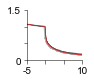

In [212]:
plt.figure(figsize=(1, 0.9))

plt.plot(sr_trange_plot-sr_trange_plot[ind_plot], sr_data_plot/sr_data_plot[ind_plot-1], c=(0.7, 0.7, 0.7, 1))
plt.plot(sr_trange_full-sr_trange_full[ind_full], reconstr_individual, c='k', lw=0.5, label='Individual')
plt.plot(sr_trange_full-sr_trange_full[ind_full], reconstr_summary, c='C3', lw=0.75, label='Summary')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(np.linspace(0, 1.5, 4))
ax.set_yticklabels([0,'','',1.5])


plt.xlim([-5, 10])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(np.linspace(0, 1.5, 4))
ax.set_yticklabels([0,'','',1.5])
ax.set_xticks([-5, 0, 5, 10])
ax.set_xticklabels([-5, '', '', 10])
plt.xlim([-5, 10])
plt.subplots_adjust(left=0.21, bottom=0.18, right=0.98, top=0.96)

### Median

In [217]:
i = inds[4]
fish_name = traces[i][:-5]

sr_trange_full, sr_data_full, ind_full = prepareStepResponse(traces[i], 
                                                        num_components_extrap = best_num_components_extrap[file_names[fish_num][trace_num]], 
                                                        use_summary=True, trace_ind = i)

# Summary plant
f = deconvolveEyePos(sr_trange_full, sr_data_full/sr_data_full[ind_full-1], summary_plant, ind_full)
f = np.copy(f)
f[ind_full-1] = f[ind_full-2]

plant_model_summary = fitting_functions.exponentialModel(sr_trange_full, summary_plant)
reconstr_summary = 72*2e-4*np.convolve(plant_model_summary, f)[:len(f)]

# Individual plant
f = deconvolveEyePos(sr_trange_full, sr_data_full/sr_data_full[ind_full-1], plants_best[fish_name], ind_full)
f = np.copy(f)
f[ind_full-1] = f[ind_full-2]

plant_model_individual = fitting_functions.exponentialModel(sr_trange_full, plants_best[fish_name])
reconstr_individual = 72*2e-4*np.convolve(plant_model_individual, f)[:len(f)]

sr_trange_plot, sr_data_plot, ind_plot = prepareStepResponse(traces[i], 
                                                        num_components_extrap = best_num_components_extrap[file_names[fish_num][trace_num]], 
                                                        use_summary=True, trace_ind = i, full=False)

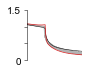

In [218]:
plt.figure(figsize=(1, 0.9))

plt.plot(sr_trange_plot-sr_trange_plot[ind_plot], sr_data_plot/sr_data_plot[ind_plot-1], c=(0.7, 0.7, 0.7, 1))
plt.plot(sr_trange_full-sr_trange_full[ind_full], reconstr_individual, c='k', lw=0.5, label='Individual')
plt.plot(sr_trange_full-sr_trange_full[ind_full], reconstr_summary, c='C3', lw=0.75, label='Summary')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(np.linspace(0, 1.5, 4))
ax.set_yticklabels([0,'','',1.5])


plt.xlim([-5, 10])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(np.linspace(0, 1.5, 4))
ax.set_yticklabels([0,'','',1.5])

ax.spines['bottom'].set_visible(False)
ax.set_xticks([])

plt.subplots_adjust(left=0.21, bottom=0.18, right=0.98, top=0.96)

### Worst

In [219]:
i = inds[-1]
fish_name = traces[i][:-5]

sr_trange_full, sr_data_full, ind_full = prepareStepResponse(traces[i], 
                                                        num_components_extrap = best_num_components_extrap[file_names[fish_num][trace_num]], 
                                                        use_summary=True, trace_ind = i)

# Summary plant
f = deconvolveEyePos(sr_trange_full, sr_data_full/sr_data_full[ind_full-1], summary_plant, ind_full)
f = np.copy(f)
f[ind_full-1] = f[ind_full-2]

plant_model_summary = fitting_functions.exponentialModel(sr_trange_full, summary_plant)
reconstr_summary = 72*2e-4*np.convolve(plant_model_summary, f)[:len(f)]

# Individual plant
f = deconvolveEyePos(sr_trange_full, sr_data_full/sr_data_full[ind_full-1], plants_best[fish_name], ind_full)
f = np.copy(f)
f[ind_full-1] = f[ind_full-2]

plant_model_individual = fitting_functions.exponentialModel(sr_trange_full, plants_best[fish_name])
reconstr_individual = 72*2e-4*np.convolve(plant_model_individual, f)[:len(f)]

sr_trange_plot, sr_data_plot, ind_plot = prepareStepResponse(traces[i], 
                                                        num_components_extrap = best_num_components_extrap[file_names[fish_num][trace_num]], 
                                                        use_summary=True, trace_ind = i, full=False)

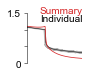

In [220]:
plt.figure(figsize=(1, 0.9))

plt.plot(sr_trange_plot-sr_trange_plot[ind_plot], sr_data_plot/sr_data_plot[ind_plot-1], c=(0.7, 0.7, 0.7, 1))
plt.plot(sr_trange_full-sr_trange_full[ind_full], reconstr_individual, c='k', lw=0.5, label='Individual')
plt.plot(sr_trange_full-sr_trange_full[ind_full], reconstr_summary, c='C3', lw=0.75, label='Summary')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(np.linspace(0, 1.5, 4))
ax.set_yticklabels([0,'','',1.5])


plt.xlim([-5, 10])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(np.linspace(0, 1.5, 4))
ax.set_yticklabels([0,'','',1.5])
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])

plt.figtext(0.98, 0.95, 'Summary', color='C3', horizontalalignment='right')
plt.figtext(0.98, 0.825, 'Individual', horizontalalignment='right')
plt.subplots_adjust(left=0.21, bottom=0.18, right=0.98, top=0.96)